In [1]:
import numpy as np
import matplotlib.pyplot as plt
import goertzel
import windowing
plt.rcParams['figure.figsize'] = [20, 10]

#max Fs per channel of AD7771
SAMPLE_RATE_HZ = 128000
TARGET_FREQ_A = 3019
TARGET_FREQ_B = 3451

# calculate a nominal block size based on the "bin_width" we want, essentially
# how much spectral bleed can we deal with
noms = goertzel.Goertzel.calculate_nominal_buffer_size(
    freq_target=1e3, 
    freq_sample=SAMPLE_RATE_HZ, 
    discr_hz=50
)
noms

gtzl = goertzel.Goertzel()
gtzl.initialize(
    freq_target=1e3,
    freq_sample=SAMPLE_RATE_HZ,
    block_size=noms.get('block_size')
)

{'k': 20,
 'w': 0.04906821793970782,
 'a': 1.9975927930303854,
 'block_size': 2561,
 'settling_time_ms': 20.0078125,
 'update_rate_hz': 49.98047637641547,
 'bin_width': 49.98047637641546}

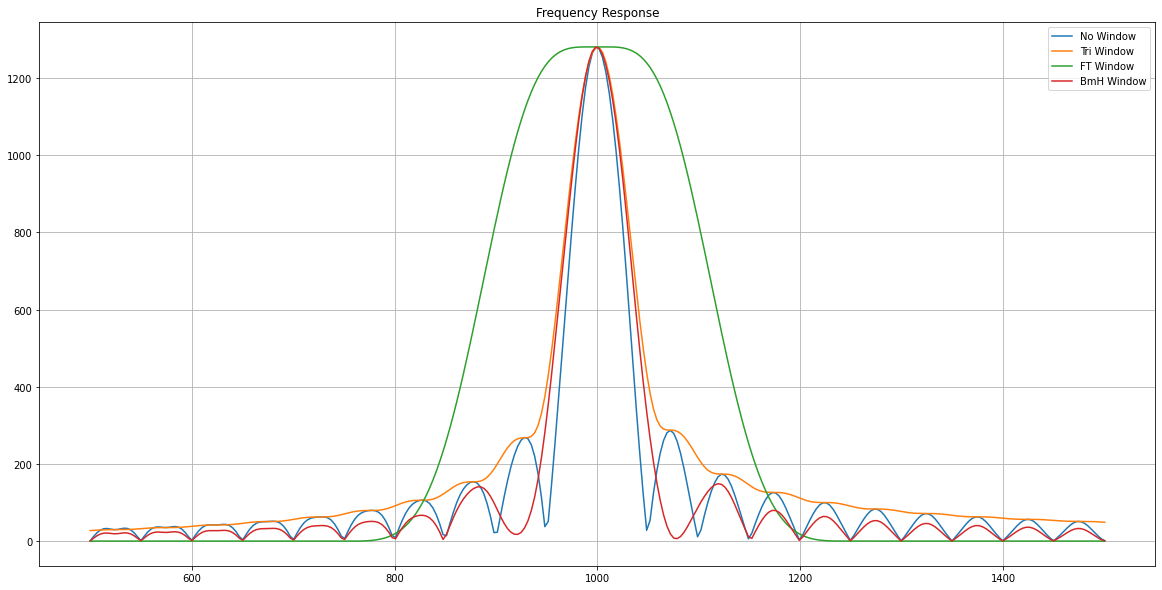

In [7]:
'''simulate goertzel filter response with different windowing functions'''
# simulate a frequency sweep on the filter
NUM_PTS=300
resp_none = gtzl.magnitude_response(500, 1.5e3, NUM_PTS, SAMPLE_RATE_HZ)
resp_triw = gtzl.magnitude_response(500, 1.5e3, NUM_PTS, SAMPLE_RATE_HZ, window='triangular')
resp_ftw = gtzl.magnitude_response(500, 1.5e3, NUM_PTS, SAMPLE_RATE_HZ, window='flat-top')
resp_bmh = gtzl.magnitude_response(500, 1.5e3, NUM_PTS, SAMPLE_RATE_HZ, window='blackman-harris')


plt.rcParams['figure.figsize'] = [20, 10]
plt.figure()
plt.grid()
plt.title('Frequency Response')
plt.plot(*resp_none, label="No Window")
plt.plot(*resp_triw, label="Tri Window")
plt.plot(*resp_ftw, label="FT Window")
plt.plot(*resp_bmh, label="BmH Window")
plt.legend(loc='best')

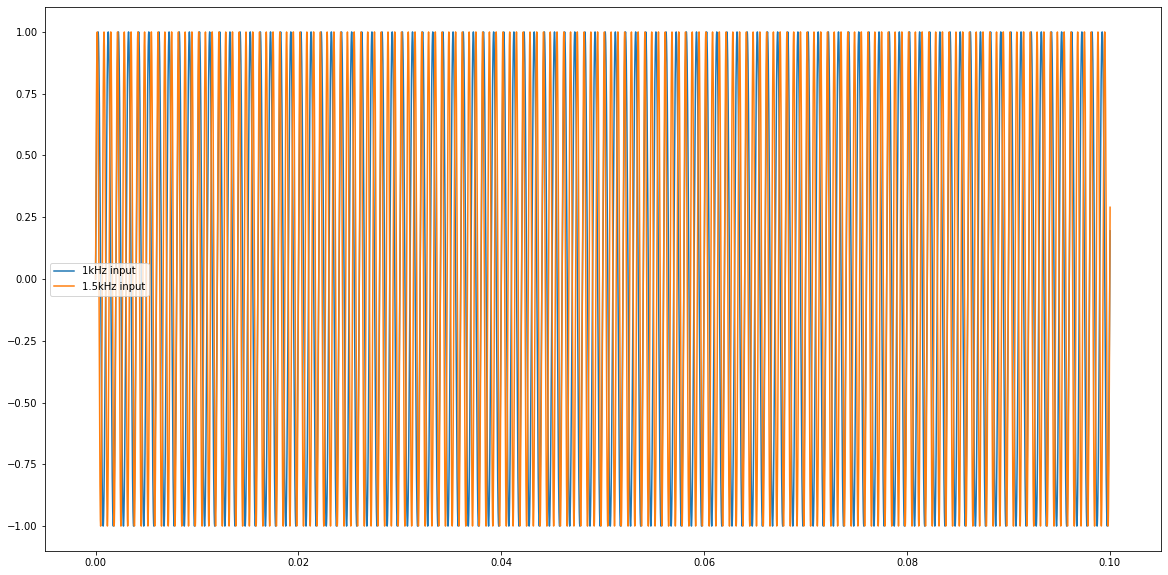

In [3]:
#test signal, 1k, NUM_BLOCKS blocks worth
NUM_BLOCKS=5
fs = gtzl.sample_rate
end_time = (1/fs)*gtzl.block_size*NUM_BLOCKS
time = np.arange(0, end_time, (1/fs))
signal_60 = np.sin(2*np.pi*60*time)
signal_1k = np.sin(2*np.pi*1e3*time)
signal_1k5 = np.sin(2*np.pi*1.5e3*time)
plt.plot(time, signal_1k, label='1kHz input')
plt.plot(time, signal_1k5, label='1.5kHz input')
plt.legend(loc='best')

26.205767070289536

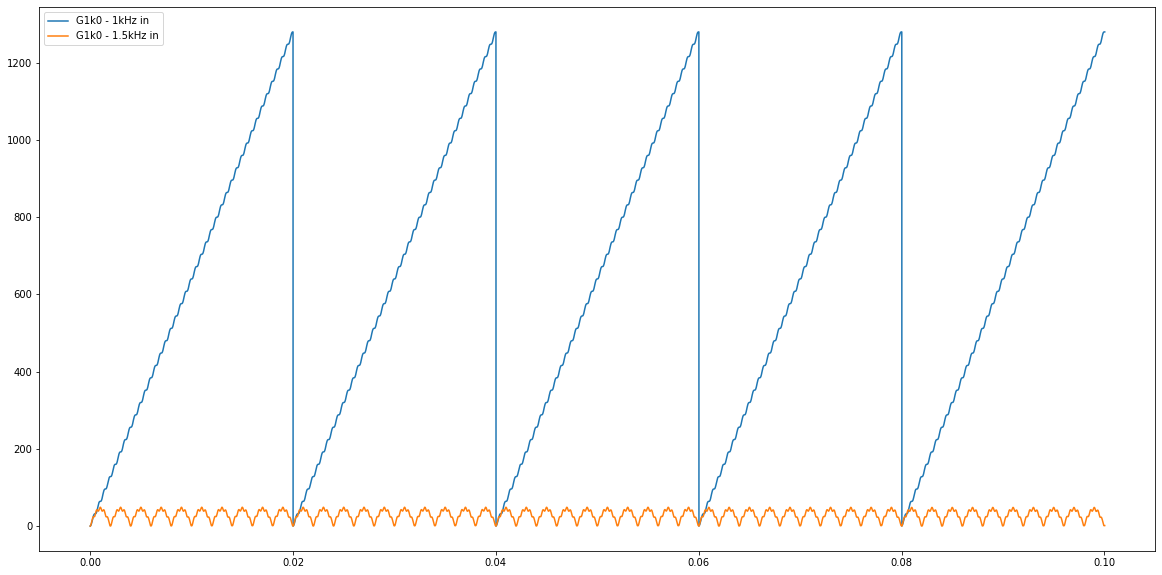

In [4]:
output1 = [gtzl.update(_s, realtime=True) for _s in signal_1k]
output2 = [gtzl.update(_s, realtime=True) for _s in signal_1k5]
plt.plot(time, output1, label='G1k0 - 1kHz in')
plt.plot(time, output2, label='G1k0 - 1.5kHz in')
plt.legend(loc='best')
# approx snr
np.ptp(output1)/np.ptp(output2)

32.46152360186202

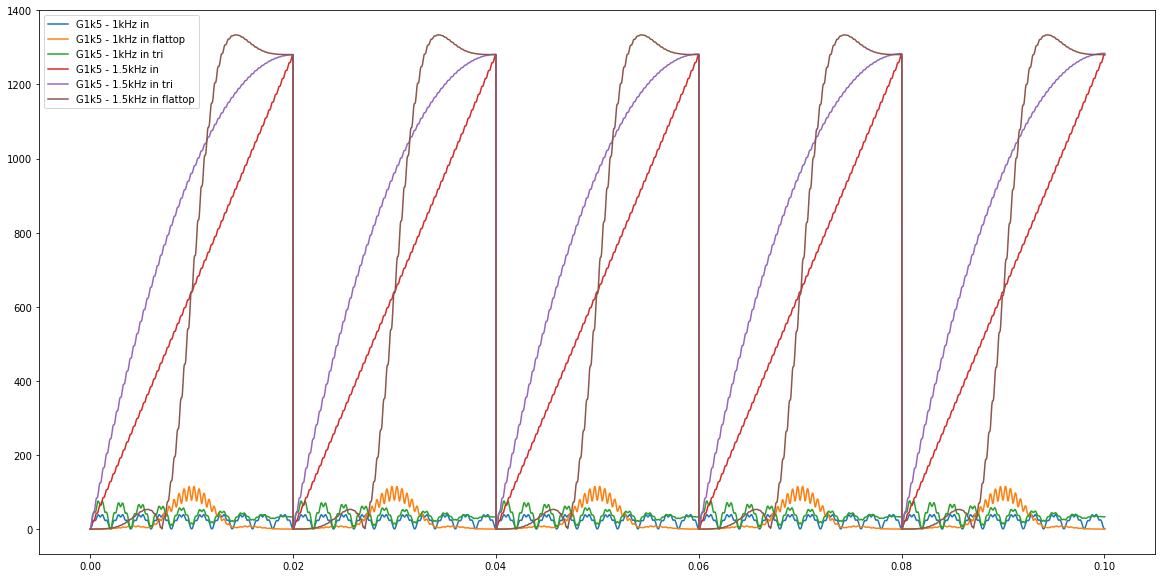

In [5]:
# create a new filter then run the same inputs, this time Ft = 1.5Khz, but use the same block size
gtzl2 = goertzel.Goertzel()
gtzl2.initialize(
    freq_target=1.5e3,
    freq_sample=SAMPLE_RATE_HZ,
    block_size=noms.get('block_size')
)
output1 = [gtzl2.update(_s, realtime=True) for _s in signal_1k]
output2 = [gtzl2.update(_s, realtime=True) for _s in signal_1k5]

# create two windowed inputs to test on gtzl2
tw = windowing.TriangularWindow(N=gtzl2.block_size)
wsignal_1k = [tw.update(_s) for _s in signal_1k]
tw.reset()
wsignal_1k5 = [tw.update(_s) for _s in signal_1k5]
output1w = [gtzl2.update(_s, realtime=True) for _s in wsignal_1k]
output2w = [gtzl2.update(_s, realtime=True) for _s in wsignal_1k5]

ftw = windowing.FlatTopWindow(N=gtzl2.block_size)
ftwwsignal_1k = [ftw.update(_s) for _s in signal_1k]
ftw.reset()
ftwwsignal_1k5 = [ftw.update(_s) for _s in signal_1k5]
output1ftw = [gtzl2.update(_s, realtime=True) for _s in ftwwsignal_1k]
output2ftw = [gtzl2.update(_s, realtime=True) for _s in ftwwsignal_1k5]

plt.plot(time, output1, label='G1k5 - 1kHz in')
plt.plot(time, output1ftw, label='G1k5 - 1kHz in flattop')
plt.plot(time, output1w, label='G1k5 - 1kHz in tri')
plt.plot(time, output2, label='G1k5 - 1.5kHz in')
plt.plot(time, output2w, label='G1k5 - 1.5kHz in tri')
plt.plot(time, output2ftw, label='G1k5 - 1.5kHz in flattop')
plt.legend(loc='best')
# approx snr, it will vary due to a non-ideal block size
np.ptp(output2)/np.ptp(output1)

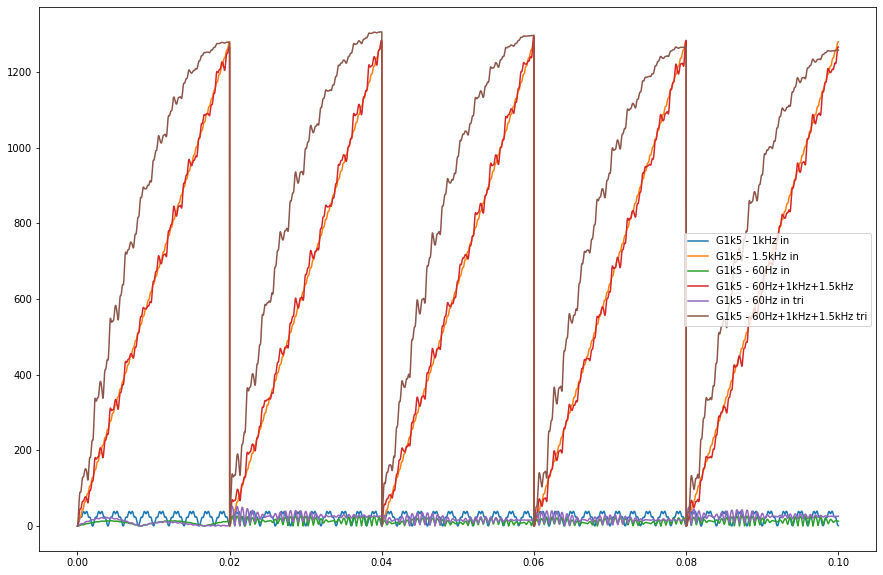

In [6]:
plt.rcParams['figure.figsize'] = [15, 10]
# run the g1k0 on the sum of all three signals
comp_signal = signal_60 + signal_1k + signal_1k5
output3 = [gtzl2.update(_s, realtime=True) for _s in signal_60]
output4 = [gtzl2.update(_s, realtime=True) for _s in comp_signal]

# apply tri window and reprocess
tw.reset()
comp_signalw = [tw.update(_s) for _s in comp_signal]
tw.reset()
signal_60w = [tw.update(_s) for _s in signal_60]
output3w = [gtzl2.update(_s, realtime=True) for _s in signal_60w]
output4w = [gtzl2.update(_s, realtime=True) for _s in comp_signalw]

plt.plot(time, output1, label='G1k5 - 1kHz in')
plt.plot(time, output2, label='G1k5 - 1.5kHz in')
plt.plot(time, output3, label='G1k5 - 60Hz in')
plt.plot(time, output4, label='G1k5 - 60Hz+1kHz+1.5kHz')
plt.plot(time, output3w, label='G1k5 - 60Hz in tri')
plt.plot(time, output4w, label='G1k5 - 60Hz+1kHz+1.5kHz tri')
plt.legend(loc='best')